# ТЧМ. Лабораторна робота 1. Частина 2

Виконав студент 
ІІ курсу магістратури,
групи ОМ-2, 
Пишко Андрій

In [ ]:
# Ресурси
import numpy as np
from numpy.linalg import norm as eu_norm  # Евклідова норма
import math

import matplotlib as mpl
import matplotlib.pyplot as plt

### Клас для моделювання перешкоди

In [2]:
# Клас, в якому визначаються та зберігаються характеристики перешкоди
class Obstacle:
    def __init__(self, obstaclePoints, m=50):
        self.m = m
        self.obstaclePoints = obstaclePoints
        self.p_0j = self.get_p_0j()  # Точки дискретизації
        self.p_k = self.get_p_k()    # Точки колокації
        self.n_k = self.get_n_k()    # Нормалі

    # Отримати довжину контуру по його точкам
    @property
    def len(self):
        return np.sum([np.linalg.norm(end-start) for start, end in zip(self.obstaclePoints[:-1], self.obstaclePoints[1:])])

    # Отримати точки дискретизації
    def get_p_0j(self):
        discretization_points = list()
        # Визначити координати та довжини частин контура
        segments_coordinates = [(start, end) for start, end in zip(self.obstaclePoints[:-1], self.obstaclePoints[1:])]
        segments_len = np.array([np.linalg.norm(end-start) for start, end in segments_coordinates])
        wild_points_number = self.m - len(self.obstaclePoints)  # Залишкові точки
        dpu = wild_points_number/self.len  # Кількість залишкові точок на одиницю проміжку
        segments_points = (segments_len*dpu).astype(int)  # Мінімальна кількість з. точок на проміжок
        # Зайві точки
        extra_point_number = wild_points_number - segments_points.sum() 
        residual_points = segments_len*dpu - segments_points
        while extra_point_number > 0:
            segment_idx = residual_points.argmax()
            segments_points[segment_idx] += 1
            residual_points[segment_idx] = 0
            extra_point_number -= 1
        for idx in np.arange(len(self.obstaclePoints)-1):
            step = (self.obstaclePoints[idx+1]-self.obstaclePoints[idx])/(segments_points[idx]+1)
            discretization_points.extend([self.obstaclePoints[idx]+step*i for i in np.arange(segments_points[idx]+1)])
        discretization_points.append(self.obstaclePoints[-1])
        return tuple(discretization_points)

    # Отримати точки колокацій
    def get_p_k(self):
        p_k = [(p_0k+p_0kp1) / 2 for p_0k, p_0kp1 in zip(self.p_0j[:-1], self.p_0j[1:])]
        return p_k

    # Отримати нормалі в точках колокацій
    def get_n_k(self):
        n_k = [np.array((-(p_0kp1[1]-p_0k[1]), p_0kp1[0]-p_0k[0])) / np.linalg.norm(p_0kp1-p_0k)
               for p_0k, p_0kp1 in zip(self.p_0j[:-1], self.p_0j[1:])]
        return n_k

    # Вивести контур перешкоди
    def plot(self, show=False):
        x, y = zip(*self.obstaclePoints)
        plt.plot(x, y, color='black')
        plt.xlabel('x')
        plt.ylabel('y')
        # plt.legend()
        # plt.grid(True)
        if show:
            plt.show()

### Клас для моделювання стаціонарного потоку

In [3]:
# Клас, який моделює процес обтікання стацiонарною течiєю фiксованої перешкоди
class FlowModeling(Obstacle):
    def __init__(self, obstaclePoints, g_0, v_inf, m=50):
        super().__init__(obstaclePoints, m)
        self.g_0 = g_0
        self.v_inf = v_inf
        self.g_j = self.get_g_j()

    # Отримати Г_і
    def get_g_j(self):
        m = self.m
        a = np.zeros((m, m))
        b = np.zeros(m)
        for k in np.arange(m-1):
            b[k] = - self.n_k[k].dot(self.v_inf)
            for j in np.arange(m):
                a[k, j] = self.n_k[k].dot(self.v_j(self.p_k[k], self.p_0j[j]))
        a[-1] = np.ones(m)
        b[-1] = self.g_0
        g = np.linalg.solve(a, b)
        return g

    # Отримати фі за неправильною формулою
    def phi(self, p):
        p_diff = p - self.p_0j
        _phi_ = p.dot(self.v_inf) + self.g_j @ np.arctan(p_diff[:, 1] / p_diff[:, 0]) / (2 * np.pi)
        return _phi_

    # Отримати фі за правильною формулою
    def phi_special(self, p):
        p_0j = np.array(self.p_0j)
        p_k = np.array(self.p_k)
        r = np.clip(np.array([np.linalg.norm(p_m_dp) for p_m_dp in (p-p_k)]), 0.01, np.inf)
        phi = (p.dot(self.v_inf) + np.cumsum(self.g_j[:-1]).dot(((p_0j[1:, 1]-p_0j[:-1, 1])*(p[0]-p_k[:, 0])-(p_0j[1:, 0]-p_0j[:-1, 0])*(p[1]-p_k[:, 1]))/r**2)/(2*np.pi)+self.g_0/(2*np.pi)*np.arctan((p[1]-p_0j[-1, 1]) / (p[0]-p_0j[-1, 0])))
        return phi

    # Отримати псі
    def psi(self, p):
        r = np.clip(np.array([eu_norm(p_diff) for p_diff in (p - self.p_0j)]), 0.01, np.inf)
        _psi_ = p[1]*self.v_inf[0] - p[0]*self.v_inf[1] - self.g_j @ np.log(r) / (2*np.pi)
        return _psi_

    # Отримати вектори швидкостей
    def v(self, p):
        _v_ = self.v_inf + self.g_j @ np.array([self.v_j(p, p_0j) for p_0j in self.p_0j])
        return _v_.flatten()

    @staticmethod
    def v_j(p, p_0j):
        r_j = max(0.01, eu_norm(p-p_0j))
        v = np.array((p_0j[1]-p[1], p[0]-p_0j[0])) / (2*np.pi*r_j**2)
        return v

    # Побудувати векторне поле швидкостей
    def plotVectorFieldV(self):
        x, y = zip(*self.obstaclePoints)
        x, y = np.meshgrid(np.linspace(np.min(x) - 1, np.max(x) + 1, 50),
                           np.linspace(np.min(y) - 0.1, np.max(y) + 0.1, 50))
        v_vector = [self.v(np.array((_x_, _y_))) for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]
        x_vector, y_vector = zip(*v_vector)
        plt.quiver(x, y, x_vector, y_vector, scale=50, color = 'b')
        self.plot()
        plt.title('Векторне поле швидкостей')
        plt.show()

    # Побудувати скалярне поле швидкостей
    def plotScalarFieldV(self):
        x, y = zip(*self.obstaclePoints)
        x, y = np.meshgrid(np.linspace(np.min(x) - 1, np.max(x) + 1, 250),
                           np.linspace(np.min(y) - 0.1, np.max(y) + 0.1, 250))
        v_scalar = np.array([eu_norm(self.v(np.array((_x_, _y_))))
                             for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]).reshape(x.shape)
        # cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "yellow", "red"])
        plt.pcolormesh(x, y, v_scalar, cmap='jet', shading='nearest')
        plt.colorbar()
        
#         v_vector = [self.v(np.array((_x_, _y_))) for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]
#         x_vector, y_vector = zip(*v_vector)
#         plt.quiver(x, y, x_vector, y_vector, scale=50, color = 'b')
        
        self.plot()
        plt.title('Скалярне поле швидкостей |V(x, y)|')
        plt.show()

    # Побудувати скалярне поле фі за формулою 4.10
    def plotScalarFieldPhiIncorrect(self):
        """
        Represents a scalar field for a scalar function φ(x, y).
        """
        x, y = zip(*self.obstaclePoints)
        x, y = np.meshgrid(np.linspace(np.min(x) - 1, np.max(x) + 1, 250),
                           np.linspace(np.min(y) - 0.1, np.max(y) + 0.1, 250))
        phi_scalar = np.array([self.phi(np.array((_x_, _y_)))
                               for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]).reshape(x.shape)
        cmap = plt.get_cmap('jet')
        colors = [cmap(i / 20) for i in np.arange(20)]
        color_step = (np.max(phi_scalar) - np.min(phi_scalar)) / len(colors)
        bounds = [np.min(phi_scalar) + color_step * i for i in np.arange(len(colors)+1)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        plt.pcolormesh(x, y, phi_scalar, cmap=cmap, norm=norm, shading='gouraud')
        plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))
        self.plot()
        plt.title('Скалярне поле $φ(x, y)$ за формулою 4.10')
        plt.show()

    # Побудувати скалярне поле фі за формулою 4.12
    def plotScalarFieldPhiCorrect(self):
        x, y = zip(*self.obstaclePoints)
        x, y = np.meshgrid(np.linspace(np.min(x) - 1, np.max(x) + 1, 250),
                           np.linspace(np.min(y) - 0.1, np.max(y) + 0.1, 250))
        phi_scalar = np.array([self.phi_special(np.array((_x_, _y_)))
                               for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]).reshape(x.shape)
        cmap = plt.get_cmap('jet')
        colors = [cmap(i / 20) for i in np.arange(20)]
        color_step = (np.max(phi_scalar) - np.min(phi_scalar)) / len(colors)
        bounds = [np.min(phi_scalar) + color_step * i for i in np.arange(len(colors)+1)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        plt.pcolormesh(x, y, phi_scalar, cmap=cmap, norm=norm, shading='gouraud')
        plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))
        self.plot()
        plt.title(r'Скалярне поле $φ(x, y)$ за формулою 4.12')
        plt.show()

    # Побудувати скалярне поле псі
    def plotScalarFieldPsi(self):
        x, y = zip(*self.obstaclePoints)
        x, y = np.meshgrid(np.linspace(np.min(x) - 1, np.max(x) + 1, 250),
                           np.linspace(np.min(y) - 0.1, np.max(y) + 0.1, 250))
        psi_scalar = np.array([self.psi(np.array((_x_, _y_)))
                               for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]).reshape(x.shape)
        cmap = plt.get_cmap('jet')
        colors = [cmap(i / 20) for i in np.arange(20)]
        color_step = (np.max(psi_scalar) - np.min(psi_scalar)) / len(colors)
        bounds = [np.min(psi_scalar) + color_step * i for i in np.arange(len(colors) + 1)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        plt.pcolormesh(x, y, psi_scalar, cmap=cmap, norm=norm, shading='gouraud')
        plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm))
        self.plot()
        plt.title('Скалярне поле ψ(x, y)')
        plt.show()


### Робота програми

In [4]:
# Задати перешкоду за опорними точками
obstaclePoints = tuple(map(lambda x: np.array(x), ((-0.143,0.3398), (-0.08,0.3833), (0,0.4), (0.08,0.3833), (0.143,0.3398), (0.183,0.28), (0.2,0.2), (0.183,0.1193), (0.143,0.0602), (0.08,0.0167), 
                                                     (0,0), 
                                                     (0.1,-0.02), (0.187,-0.084), (0.235,-0.165), (0.25,-0.25), (0.235,-0.335), (0.187,-0.42), (0.1,-0.479), (0,-0.5), (-0.1,-0.479), (-0.187,-0.42), (-0.235,-0.3353))))

m = 50  # Кількість точок дискретних особливостей
angle = math.pi/4.  # Кут потоку
g0 = 0  # Параметр Г_0

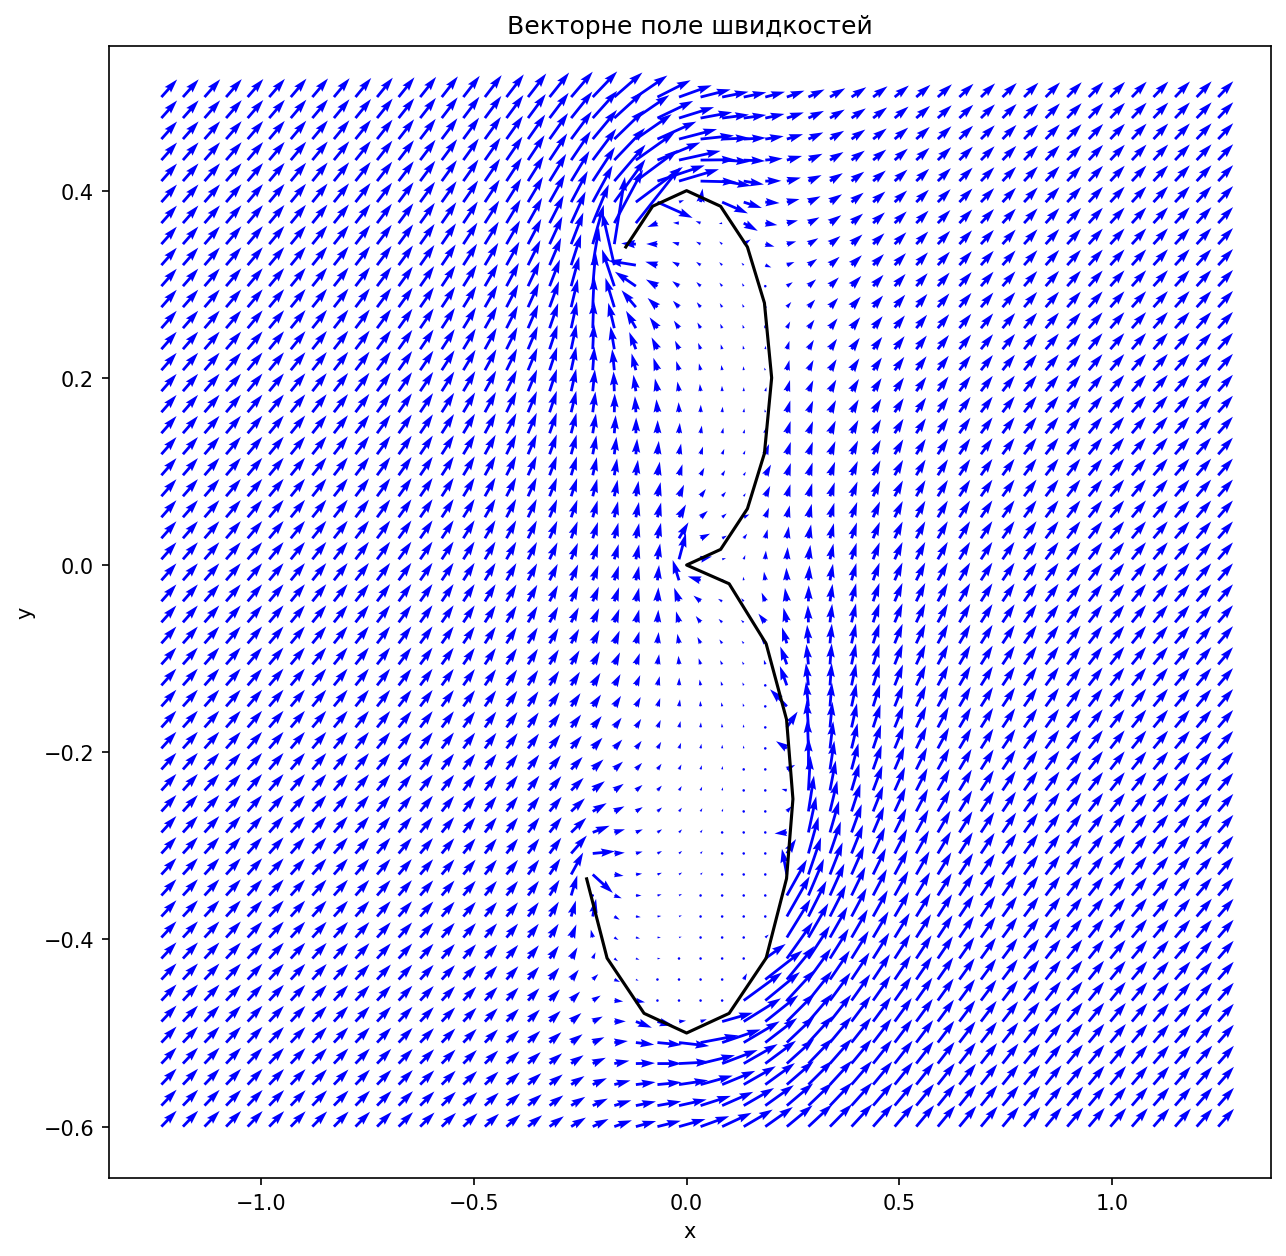

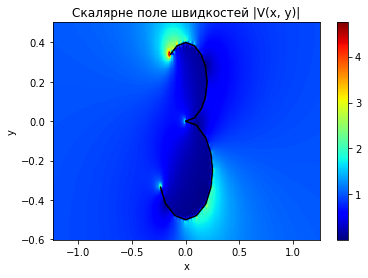

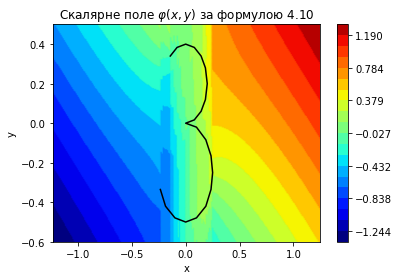

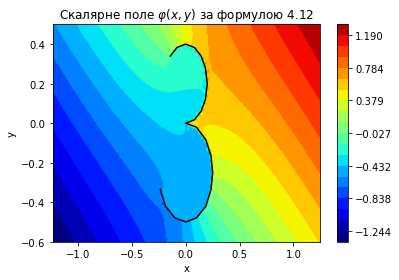

In [ ]:
# Ініціалізувати клас моделювання
vІnf = np.array((math.cos(angle), math.sin(angle)))
flowModeling = FlowModeling(obstaclePoints, g0, vІnf, m)
# Вивести векторне поле швидкостей
flowModeling.plotVectorFieldV()
# Вивести скалярне поле швидкостей
flowModeling.plotScalarFieldV()
# Вивести скалярне поле Фі, визначене за неправильною формулою
flowModeling.plotScalarFieldPhiIncorrect()
# Вивести скалярне поле Фі, визначене за правильною формулою
flowModeling.plotScalarFieldPhiCorrect()
# Вивести скалярне поле Псі
flowModeling.plotScalarFieldPsi()